In [3]:
import or_gym
import numpy as np

from scipy.optimize import minimize


def base_stock_policy(policy, env):
    '''
    Implements a re-order up-to policy. This means that for
    each node in the network, if the inventory at that node 
    falls below the level denoted by the policy, we will 
    re-order inventory to bring it to the policy level.

    For example, policy at a node is 10, current inventory
    is 5: the action is to order 5 units.
    '''

    # Get echelon inventory levels
    if env.period == 0:
        inv_ech = np.cumsum(env.I[env.period] + env.T[env.period])
    else:
        inv_ech = np.cumsum(env.I[env.period] + env.T[env.period] - env.B[env.period-1, :-1])
        
    # Get unconstrained actions
    unc_actions = policy - inv_ech
    unc_actions = np.where(unc_actions>0, unc_actions, 0)

    # Ensure that actions can be fulfilled by checking 
    # constraints
    inv_const = np.hstack([env.I[env.period, 1:], np.Inf])
    actions = np.minimum(env.c, np.minimum(unc_actions, inv_const))
    return actions


def dfo_func(policy, env, *args):
    '''
    Runs an episode based on current base-stock model 
    settings. This allows us to use our environment for the 
    DFO optimizer.
    '''
    env.reset() # Ensure env is fresh
    rewards = []
    done = False
    while not done:
        action = base_stock_policy(policy, env)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break
            
    rewards = np.array(rewards)
    prob = env.demand_dist.pmf(env.D, **env.dist_param)
    
    # Return negative of expected profit
    return -1 / env.num_periods * np.sum(prob * rewards)


def optimize_inventory_policy(env, fun, init_policy=None, method='Powell'):
  
    if init_policy is None:
        init_policy = np.ones(env.num_stages-1)
      
    # Optimize policy
    optim_result = minimize(fun=fun, x0=init_policy, args=env, method=method)
    policy = optim_result.x.copy()
  
    # Policy must be positive integer
    policy = np.round(np.maximum(policy, 0), 0).astype(int)
    
    return policy, optim_result


def eval_baseline_policy_on_env(env_name, n_eval_episodes):
    env = or_gym.make(env_name)

    # Get the optimal baseline policy
    policy, optim_result = optimize_inventory_policy(env, dfo_func)

    print('Reorder levels:', policy)
    print('Optimizer info:')
    print(optim_result)

    rewards = np.empty(shape=(n_eval_episodes, env.periods))
    
    for episode in range(n_eval_episodes):
        env.reset()
        for timestep in range(env.periods):
            action = base_stock_policy(policy, env)
            obs, reward, _, _ = env.step(action)
            rewards[episode,timestep] = reward

    np.save(f'baseline_eval_rewards.npy', rewards)



Reorder levels: [115  10  28]
Optimizer info:
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.24102348149186117
       x: [ 1.149e+02  9.862e+00  2.838e+01]
     nit: 3
   direc: [[ 0.000e+00  0.000e+00  1.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 1.479e+01  8.220e-01  3.302e+00]]
    nfev: 124


/var/folders/v5/b2527n0x4zgb6khjjq0g22k40000gn/T/ipykernel_2321/2686649337.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


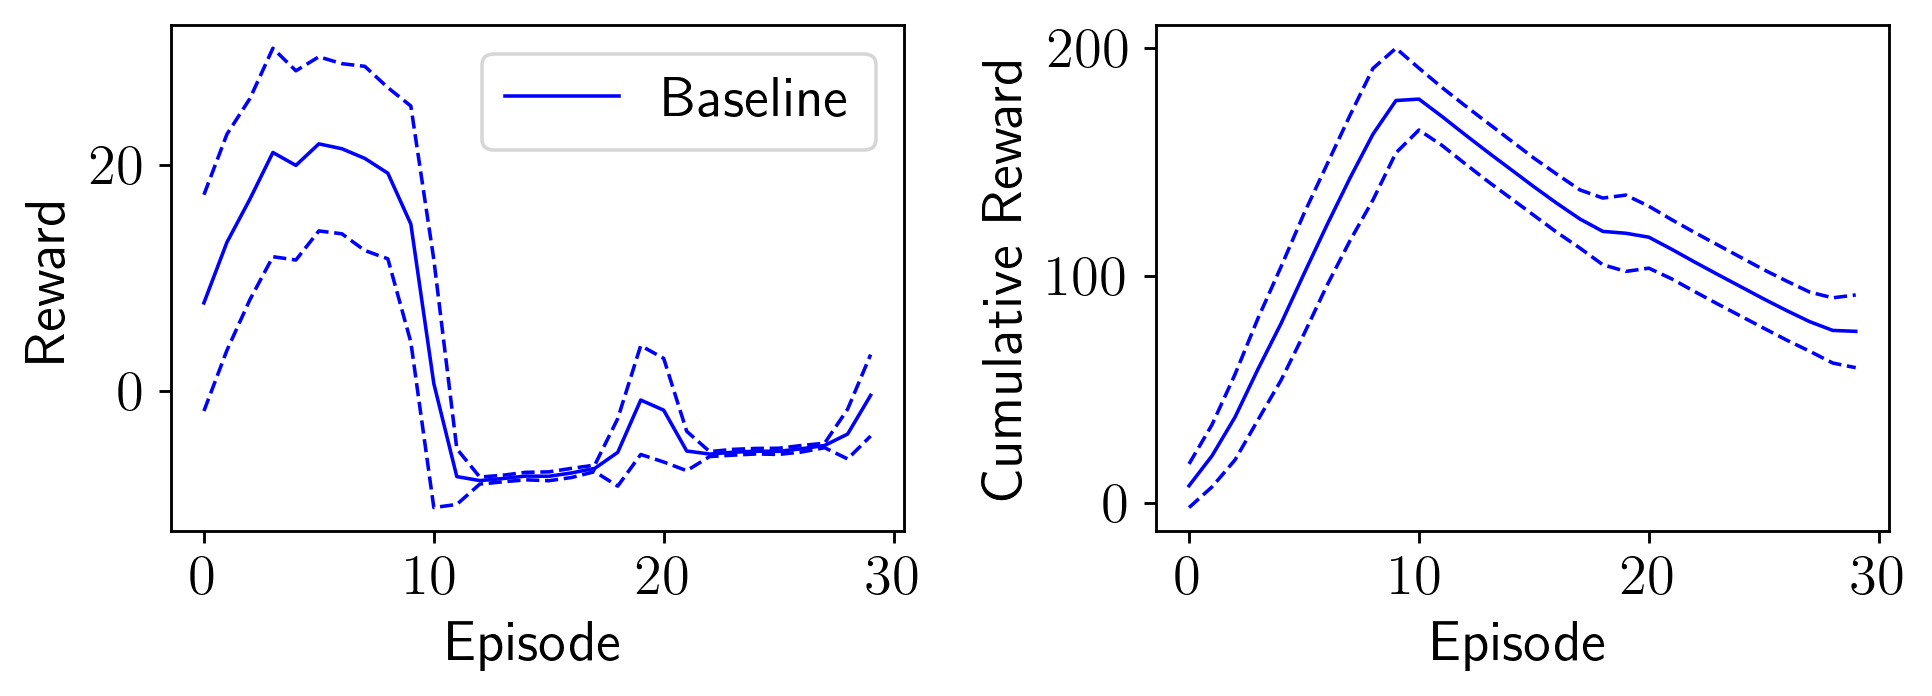

In [4]:
import matplotlib.pyplot as plt

eval_baseline_policy_on_env('InvManagement-v1', 100)

plt.rcParams['figure.dpi'] = 256
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16

rewards = np.load('baseline_eval_rewards.npy')

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(8, 3)

color = 'blue'
linewidth=1.0

reward_means = np.mean(rewards, axis=0)
reward_stds = np.std(rewards, axis=0)

ax[0].plot(reward_means, linewidth=linewidth, label='Baseline', color=color)
ax[0].plot(reward_means + reward_stds, linewidth=linewidth, color=color, linestyle='--')
ax[0].plot(reward_means - reward_stds, linewidth=linewidth, color=color, linestyle='--')

cumulative_rewards = np.cumsum(rewards, axis=1)
cumulative_reward_means = np.mean(cumulative_rewards, axis=0)
cumulative_reward_stds = np.std(cumulative_rewards, axis=0)

ax[1].plot(cumulative_reward_means, linewidth=linewidth, label='Baseline', color=color)
ax[1].plot(cumulative_reward_means + cumulative_reward_stds, linewidth=linewidth, color=color, linestyle='--')
ax[1].plot(cumulative_reward_means - cumulative_reward_stds, linewidth=linewidth, color=color, linestyle='--')

ax[0].legend()
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Reward')

ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Cumulative Reward')

fig.tight_layout()
fig.show()
